In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import pandas as pd
from generate_verification_data import models

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)
sns.set_palette("Dark2")

In [11]:
ttf_results = pd.read_parquet("verification/ttf.parquet")
ttf_results

,Model,Time-to-Feedback,TTF (Raw),Repetition,Execution time,Neuroticism
0,Low neuro,high,5.0,0,6.138038,low
1,Low neuro,high,5.0,1,8.173255,low
2,Low neuro,high,5.0,2,6.662627,low
3,Low neuro,high,5.0,3,3.920028,low
4,Low neuro,high,5.0,4,2.784780,low
...,...,...,...,...,...,...
7195,"ExGaussian fit,\nhigh neuro",medium,2.5,595,4.627890,high
7196,"ExGaussian fit,\nhigh neuro",medium,2.5,596,4.348078,high
7197,"ExGaussian fit,\nhigh neuro",medium,2.5,597,4.966646,high
7198,"ExGaussian fit,\nhigh neuro",medium,2.5,598,6.056449,high


In [12]:
duration_results = pd.read_parquet("verification/duration.parquet")
duration_results

,Configuration,Time-to-Feedback,TTF (Raw),Repetition,Step,Execution time
0,Low neuro,medium,2.5,0,1,3.254080
1,Low neuro,medium,2.5,0,2,3.538223
2,Low neuro,medium,2.5,0,3,8.585070
3,Low neuro,medium,2.5,0,4,4.516183
4,Low neuro,medium,2.5,0,5,4.596289
...,...,...,...,...,...,...
86395,"ExGaussian fit,\nhigh neuro",high,5.0,599,8,3.360915
86396,"ExGaussian fit,\nhigh neuro",high,5.0,599,9,4.093096
86397,"ExGaussian fit,\nhigh neuro",high,5.0,599,10,5.505328
86398,"ExGaussian fit,\nhigh neuro",high,5.0,599,11,16.837069


In [113]:
transition_results = pd.read_parquet("verification/transitions.parquet")
transition_results["Transition"] = transition_results["Transition"].replace({"Same level": "No change"})
transition_results = transition_results.rename(columns={"Transition": "Change in TTF"})
transition_results

,Model,Origin TTF,Destination TTF,Repetition,Execution time,Change in TTF
0,Low neuro,low,medium,0,4.796311,Lower -> higher
1,Low neuro,low,medium,1,6.028927,Lower -> higher
2,Low neuro,low,medium,2,7.470195,Lower -> higher
3,Low neuro,low,medium,3,4.466069,Lower -> higher
4,Low neuro,low,medium,4,6.252382,Lower -> higher
...,...,...,...,...,...,...
21595,"ExGaussian fit,\nhigh neuro",high,high,595,3.337469,No change
21596,"ExGaussian fit,\nhigh neuro",high,high,596,3.862939,No change
21597,"ExGaussian fit,\nhigh neuro",high,high,597,11.990740,No change
21598,"ExGaussian fit,\nhigh neuro",high,high,598,6.133709,No change


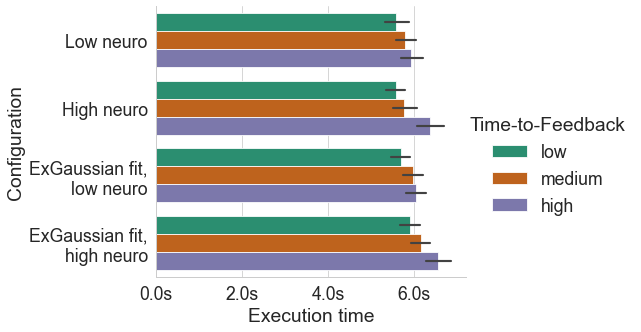

Time-to-Feedback
high      0.079328
low       0.018910
medium    0.014463
Name: Execution time, dtype: float64

In [14]:
fg = sns.catplot(
    kind="bar",
    # join=False,
    dodge=True,
    data=ttf_results,
    y="Model",
    order=models.keys(),
    x="Execution time",
    hue="Time-to-Feedback",
    hue_order=["low", "medium", "high"],
    aspect=1.5,
)
# fg.set(xlim=(None, 8))
# fg.set_axis_labels("Execution time [s]", "Configuration")
# fg.legend.set_title("Time-to-feedback")
fg.set_ylabels("Configuration")
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:2.1f}s"))
plt.show()

In [38]:
ix = pd.IndexSlice

neuro_ttfs = (
    ttf_results
    .groupby(["Model", "Neuroticism", "Time-to-Feedback"])["Execution time"]
    .mean()
    .groupby(["Neuroticism", "Time-to-Feedback"])
    .mean()
)
(neuro_ttfs.loc[ix[:, "high"]] - neuro_ttfs.loc[ix[:, "low"]]) / neuro_ttfs.loc[ix[:, "low"]]

Neuroticism
high    0.125281
low     0.062291
Name: Execution time, dtype: float64

In [27]:
(
    ttf_results
    .groupby(["Model", "Time-to-Feedback"])["Execution time"]
    .mean()
    .groupby("Model").apply(lambda df: (df.loc[pd.IndexSlice[:, "high", :]] - df.loc[pd.IndexSlice[:, "low", :]]) / df.loc[pd.IndexSlice[:, "low", :]])

)

Model                        Model                      
ExGaussian fit,\nhigh neuro  ExGaussian fit,\nhigh neuro    0.110109
ExGaussian fit,\nlow neuro   ExGaussian fit,\nlow neuro     0.062488
High neuro                   High neuro                     0.141360
Low neuro                    Low neuro                      0.062089
Name: Execution time, dtype: float64

In [28]:
(
    ttf_results
    .groupby(["Model", "Time-to-Feedback"])["Execution time"]
    .mean()
    # .groupby("Model").apply(lambda df: (df.loc[pd.IndexSlice[:, "high", :]] - df.loc[pd.IndexSlice[:, "low", :]]) / df.loc[pd.IndexSlice[:, "low", :]])

)

Model                        Time-to-Feedback
ExGaussian fit,\nhigh neuro  high                6.555183
                             low                 5.904993
                             medium              6.151608
ExGaussian fit,\nlow neuro   high                6.038045
                             low                 5.682930
                             medium              5.961186
High neuro                   high                6.359560
                             low                 5.571913
                             medium              5.769866
Low neuro                    high                5.927497
                             low                 5.580977
                             medium              5.790325
Name: Execution time, dtype: float64

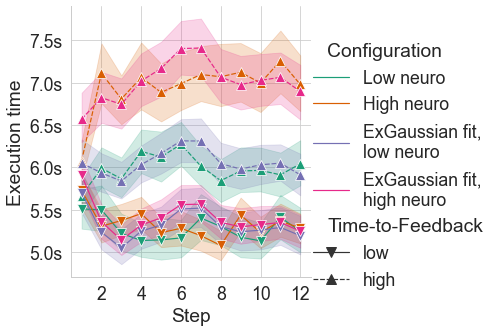

Configuration                Time-to-Feedback  Step
ExGaussian fit,\nhigh neuro  high              1       6.569532
                                               2       6.823753
                             low               1       5.907761
                                               2       5.357915
                             medium            1       6.171741
                                               2       5.903707
ExGaussian fit,\nlow neuro   high              1       6.051498
                                               2       5.934459
                             low               1       5.702931
                                               2       5.232635
                             medium            1       5.967503
                                               2       5.769362
High neuro                   high              1       6.075669
                                               2       7.112314
                             low               1    

In [72]:
fg = sns.relplot(
    kind="line",
    err_style="band",
    errorbar=("ci", 95),
    data=duration_results,
    x="Step",
    y="Execution time",
    hue="Configuration",
    hue_order=models.keys(),
    style="Time-to-Feedback",
    style_order=["low", "high"],
    markers=["v", "^"],
    markersize=10,
)
for ax in fg.axes.flat:
    ax.xaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:0.1f}s"))
fg.set_axis_labels("Step", "Execution time")

for legend_handle in fg.legend.legendHandles:
    legend_handle.set_markersize(10)
    # print(dir(legend_handle))
    # break

plt.show()

In [87]:
mean_durs = duration_results.groupby(["Configuration", "Time-to-Feedback", "Step"])["Execution time"].mean()
((mean_durs.loc[ix[:, "low", 12]] - mean_durs.loc[ix[:, "low", 1]]) / mean_durs.loc[ix[:, "low", 1]]).mean()

-0.08186427216883249

In [103]:
high_neuro_durs = (
    mean_durs.loc[ix[["ExGaussian fit,\nhigh neuro", "High neuro"], "high", [1, 12]]]
)
((high_neuro_durs.loc[ix[:, :, 12]] - high_neuro_durs.loc[ix[:, :, 1]]) / high_neuro_durs.loc[ix[:, :, 1]]).mean()

0.09938095297508892

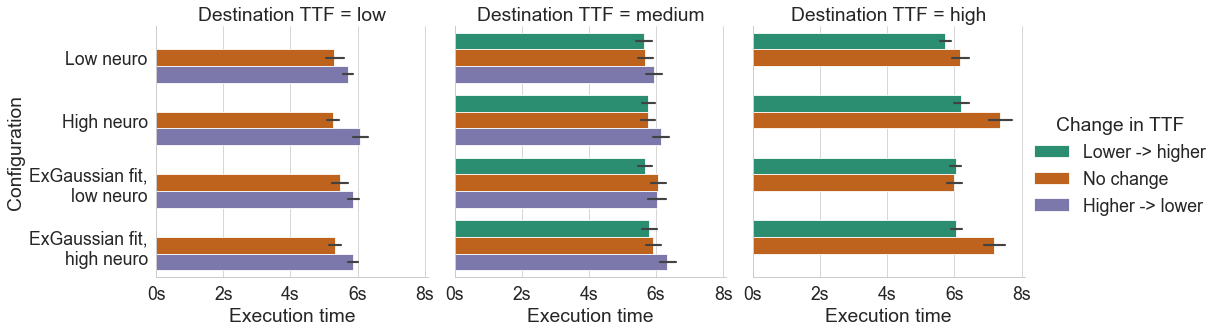

In [116]:
fg = sns.catplot(
    kind="bar",
    data=transition_results,
    y="Model",
    x="Execution time",
    hue="Change in TTF",
    hue_order=["Lower -> higher", "No change", "Higher -> lower"],
    col="Destination TTF",
    col_order=["low", "medium", "high"],
    # dodge=False,
    # aspect=1.5,
)
fg.set_ylabels("Configuration")
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:1.0f}s"))
plt.show()

# transition_results.groupby(["Destination TTF", "Model", "Transition"], observed=True)["Execution time"].mean()